# ***Data Intensive Computing: Phase 1-3***
*Contributors: Seungmin Lee, David Huang*

*Python Ver: 3.9.7*

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import re
import pickle
import webbrowser
import warnings
from collections import Counter
from scipy import stats
from sklearn import (decomposition, datasets, tree, metrics)
from sklearn.preprocessing import (scale, StandardScaler)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import linear_model
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor)
from sklearn.tree import (DecisionTreeRegressor, export_graphviz)
from flask import Flask
from flask import render_template, request, url_for, redirect
from threading import Timer

**Phase 1:** Deliverables
---
1. **Problem Statement:** Form a title and problem statement that clearly state the problem
and questions you are trying to answer. Additionally:
    - Discuss the background of the problem leading to your objectives. Why is it a significant problem?
    - Explain the potential of your project to contribute to your problem domain. Discuss why this contribution is crucial?
2. **Data Sources:** Collect your data. Your data can come from multiple sources.
    - For example, Medical, Bank, sports, health, Kaggle, Amazon reviews, Twitter, Youtube, Reddit, etc. 
    - This data has to be large enough for the data analysis to yield significance. At least 2000 rows.
3. **Data Cleaning/Processing:** Your dataset has to be cleaned and properly processed. Please submit a report where you explain each processing/cleaning step properly. We expect to see comments and markup for this step. 
    - In order to get full marks you must clearly document 7 (10 for 587 students) distinct processing/cleaning operations.
4. **Exploratory Data Analysis (EDA):** Perform exploratory data analysis as defined in the NIST publication [2] and as originally described by John Tukey [4,5]. Record the outcomes and what you learned and how you will use this information.
    - For example, in choosing features (columns) and dropping columns, and in short feature engineering. 
    - You need to demonstrate 7 (10 for 587 students) different, significant and relevant EDA operations and describe how you used these to process the data sets further to provision them for downstream modeling and analytics. Figures and tables should be included where relevant.

Construction Permits in Austin, TX
---
**Problem Statement:**
- The problem statement is to predict the annual revenue from the construction permits. Some questions are, in Austin, TX, what is the breakdown of the residential permits that were approved? Who might be the most popular contractor out of the permits? We are also trying to find if there is any relationship between the amount of a job valuation to the structure and size of the lot. Besides those questions, the end goal would be to predict the annual revenue from the construction permits as well as predicting the cost of a specific construction job. 

**Motivation:**
- The motivation for this project would be to ensure proper supply chain demands within the current supply chain issues and making sure all materials and projects to be completed within the designated time for company's to hit their revenue go. It also helps to make sure all the resident's constructions are within their estimated time and expenses. 
- A motivation would be especially nowadays during the aftermath of global supply shortages, construction costs have increased tremedously. From a company's standpoint, there would need to be a way to predict the revenue based on the supply cost. From a resident's standpoint, there would need to be a way to predict the amount of money that needs to be saved for a specific construction project and the amount of time in case anything happens. 
- Another motivation would be due to the increasing in prices, the construction project and plans would need to be delayed if the budget was exceeded. It would be an inconvenience to the resident, the resident's neighborhood, and contribute to overall delay of plans as well as stress to overall the contractors so it would be better if there was a way to predict the valuation of the project it would be easier for everyone. 

**Data Source:**
- [Issued Construction Permits - data.austintexas.gov](https://data.austintexas.gov/Building-and-Development/Issued-Construction-Permits/3syk-w9eu)

    *Note: CSV in use for this project will be slightly altered to reduce file size. (Original Size: 1.29GB)*

**Things to Consider:**
- The values in the Total Job Valuation column are often N/A or valued at $0

Initial Cleaning/Filtering
---
The original file had a file size of 1.29GB and contained over 2 million rows of data. 
To reduce the dataset we wish to work with we initially removed unneccesary columns and decided to focus primarily on residential construction.
There were several instances where the total job valuation were either N/A or had a value of 0. 
To better determine which job was paid for we removed those instances.
As there were records of data since 1921, we wanted to take in only the recent years since 2017.
By performing all of these, we managed to reduce the file to 26.5MB, with approximately 56,000 rows of data. This would be considered four cleaning processes because it is three different queries and dropping of columns. 
```
original_data = pd.read_csv('Dataset/Issued_Construction_Permits.csv')
original_data = original_data.drop(['Link','Location','Contractor Address 1','Contractor Address 2','Applicant Phone','Applicant Address 1','Applicant Address 2'],axis=1)
original_data = original_data[original_data['Permit Class Mapped'] == 'Residential']
original_data = original_data[original_data['Total Job Valuation'] > 0]
original_data = original_data[original_data['Calendar Year Issued'] >= 2017]

original_data.to_csv('Dataset/ICP_Residential_Austin2017up.csv',index=False)
```
- *Original File:* Issued_Construction_Permits.csv
- *Outputted File:* ICP_Residential_Austin2017up.csv

Data Cleaning / Processing
---
Besides the original cleaning and filtering, other methods of data cleaning and processing are deleting rows where there are empty values, changing categorical data from strings into categorical in numbers, deleting columns through the usage of PCA, and finally, scaling the data set into normalizing it for the PCA. Majority of this data cleaning and processing is used for the production of PCA because it requires numerical entries with no missing values. More information is given through the PCA portion. 

In [2]:
data = pd.read_csv('Dataset/ICP_Residential_Austin2017up.csv')
data.shape

(55976, 61)

Visualizing Various Types of Permits Issued Along with its Purpose
---
Upon first glance of the dataset, there exists 5 different types of construction permits that were issued: 
- Building Permits
- Mechanical Permits
- Plumbing Permits
- Driveway/Sidewalk Permits
- Electrical Permits

To gain a rough insight as to what our dataset holds, we started off with visualizing the number of permits issued through the years 2017-2022, taking into account of different construction permits as well as the general purpose for each of those permits.

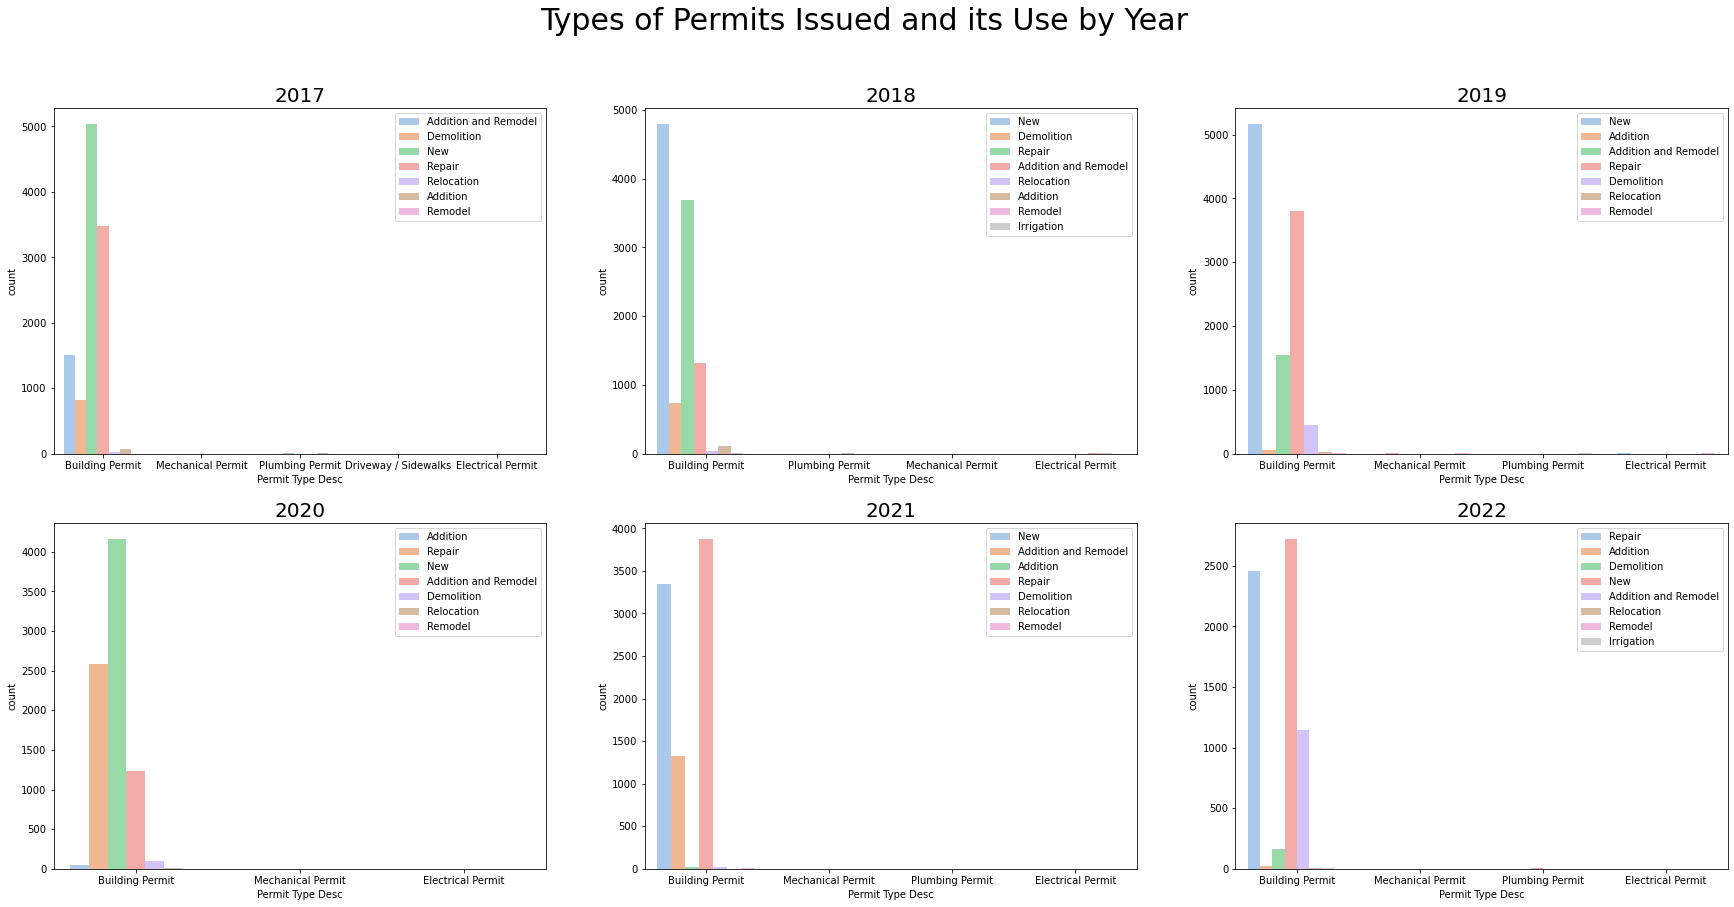

In [3]:
# Count of Permit Types Issued from Years 2017-2022
fig, axes = plt.subplots(2,3,figsize=(30,14))
fig.suptitle('Types of Permits Issued and its Use by Year',size=30)
# Count Plots
sns.countplot(ax=axes[0,0],data=data[data['Calendar Year Issued']==2017],x='Permit Type Desc',hue='Work Class',palette='pastel')
axes[0,0].set_title('2017',size=20)
axes[0,0].legend(loc='upper right')
sns.countplot(ax=axes[0,1],data=data[data['Calendar Year Issued']==2018],x='Permit Type Desc',hue='Work Class',palette='pastel')
axes[0,1].set_title('2018',size=20)
axes[0,1].legend(loc='upper right')
sns.countplot(ax=axes[0,2],data=data[data['Calendar Year Issued']==2019],x='Permit Type Desc',hue='Work Class',palette='pastel')
axes[0,2].set_title('2019',size=20)
axes[0,2].legend(loc='upper right')
sns.countplot(ax=axes[1,0],data=data[data['Calendar Year Issued']==2020],x='Permit Type Desc',hue='Work Class',palette='pastel')
axes[1,0].set_title('2020',size=20)
axes[1,0].legend(loc='upper right')
sns.countplot(ax=axes[1,1],data=data[data['Calendar Year Issued']==2021],x='Permit Type Desc',hue='Work Class',palette='pastel')
axes[1,1].set_title('2021',size=20)
axes[1,1].legend(loc='upper right')
sns.countplot(ax=axes[1,2],data=data[data['Calendar Year Issued']==2022],x='Permit Type Desc',hue='Work Class',palette='pastel')
axes[1,2].set_title('2022',size=20)
axes[1,2].legend(loc='upper right')

As shown in the figure(s) above, we can see that building permits account to a vast majority of the dataset with certain permits having little to no use during some of the years.

Separately Portraying Counts for Building and Non-Building Permits
---
We will separate the subplots into 2 different categories: Building Permits and Non-Building Permits. The reasoning relates to what we found from the previous figure and how the data dealing with Building Permits greatly differs from the rest and masks what the counts are for Non-Building Permits. To start off, we will plot the counts of just the amount of permits issued over the years.

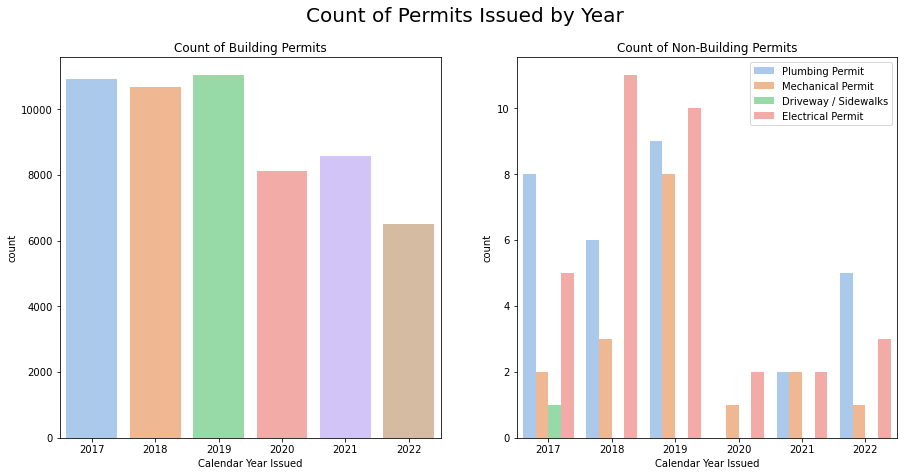

In [4]:
# Separate Plots for Building and Non-Building Permits
fig, axes = plt.subplots(1,2,figsize=(15,7))
fig.suptitle('Count of Permits Issued by Year',size=20)
# Count Plots
sns.countplot(ax=axes[0],data=data[data['Permit Type Desc']=="Building Permit"],x='Calendar Year Issued',palette='pastel')
axes[0].set_title('Count of Building Permits')
sns.countplot(ax=axes[1],data=data[data['Permit Type Desc']!="Building Permit"],x='Calendar Year Issued',hue='Permit Type Desc',palette='pastel')
axes[1].set_title('Count of Non-Building Permits')
axes[1].legend(loc='upper right')

We can see that the number of permits issued overall were slightly consistent from 2017-2019 but then saw a decline afterwards during the span of 2020-2022, with the number of Non-Building Permits issued drastically decline when compared to the number of Building Permits issued.

Analysis for Building Permits
---
Since we know that Building Permits account for majority of the data, we want to visualize a better breakdown on what goes on for the permits each year. By focusing mainly on Building Permits for this section, it'll be easier to see the difference between the work classes. For the pie chart, we need to adjust the dataframe into a series. During the process, we will combine the values from the Relocation and Remodel column as the count of each are respectively low compared to other work classes.

Text(0.5, 1.0, 'Percentage of Work Class from 2017-2022')

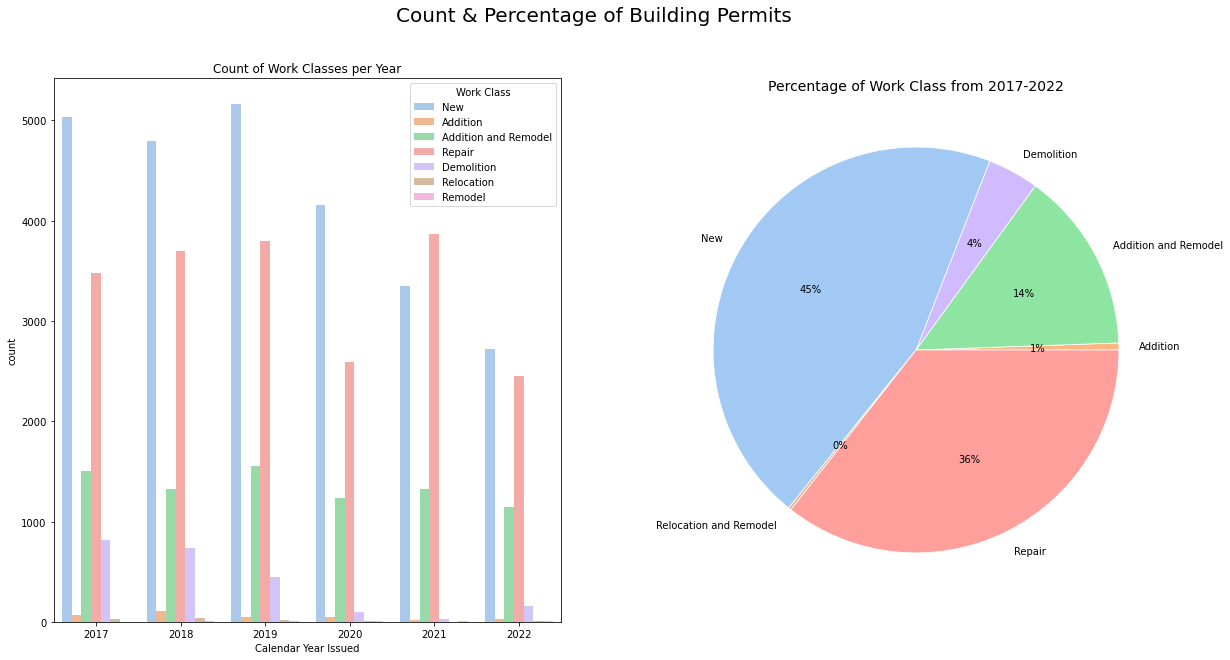

In [5]:
# Count & Percentage of Building Permits
fig, axes = plt.subplots(1,2,figsize=(20,10))
fig.suptitle('Count & Percentage of Building Permits',size=20)
# For ease of use, created a separate copy of a dataframe containing only Building Permits
build_data=data[data['Permit Type Desc']=="Building Permit"]
# Count Plot
sns.countplot(ax=axes[0],data=build_data,x='Calendar Year Issued',hue='Work Class',palette='pastel')
axes[0].set_title('Count of Work Classes per Year')
# Creating a series containing counts of work class performed to be used as input for pie chart
pieData=build_data.groupby('Work Class').count()['Total Job Valuation']
# Relocation and Remodel have been combined as both were relatively low in comparison to other work classes (Relocation:100, Remodel:31)
# This would be considered the fifth data cleaning and preprocessing operation. 
pieData['Relocation and Remodel'] = pieData['Relocation']+pieData['Remodel']
pieData = pieData.drop(['Remodel','Relocation']).reindex(index = ['Addition','Addition and Remodel','Demolition','New','Relocation and Remodel','Repair'])
# Pie Chart
c = sns.color_palette('pastel')[0:6]
colors = c[1:3]+[c[4],c[0],c[5],c[3]]
axes[1].pie(pieData,labels=list(pieData.index.values),colors=colors,autopct='%.0f%%',wedgeprops={'linewidth':0.75,'edgecolor':'white'})
axes[1].set_title("Percentage of Work Class from 2017-2022", fontsize=14)

Similar to the trend we discovered before, the number of 'New', 'Addition' and 'Demolition' work classes decreased after 2019. The rest of the work classes ('Addition and Remodel', 'Repair', 'Relocation and Remodel') remained relatively the same throughout the years. In terms of percentage, 'New' and 'Repair' were the most dominant out of the work classes.

Analysis for Non-Building Permits
---
Non-Building Permits accounts for a very small percentage of the dataset and knowing what to further filter out will make it easier in the long run in determining which features to keep.

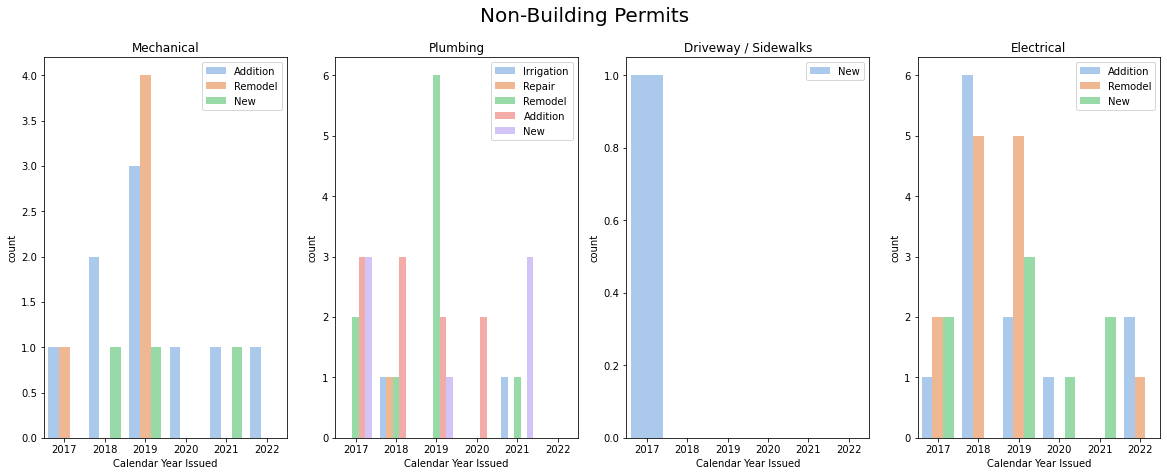

In [6]:
# Count of Non-Building Permits
fig, axes = plt.subplots(1,4,figsize=(20,7),sharex=True)
fig.suptitle('Non-Building Permits',size=20)
# Count Plots per Permit Type
sns.countplot(ax=axes[0],data=data[data['Permit Type Desc']=="Mechanical Permit"],x='Calendar Year Issued',hue='Work Class',palette='pastel')
axes[0].set_title('Mechanical')
axes[0].legend(loc='upper right')
sns.countplot(ax=axes[1],data=data[data['Permit Type Desc']=="Plumbing Permit"],x='Calendar Year Issued',hue='Work Class',palette='pastel')
axes[1].set_title('Plumbing')
axes[1].legend(loc='upper right')
sns.countplot(ax=axes[2],data=data[data['Permit Type Desc']=="Driveway / Sidewalks"],x='Calendar Year Issued',hue='Work Class',palette='pastel')
axes[2].set_title('Driveway / Sidewalks')
axes[2].legend(loc='upper right')
sns.countplot(ax=axes[3],data=data[data['Permit Type Desc']=="Electrical Permit"],x='Calendar Year Issued',hue='Work Class',palette='pastel')
axes[3].set_title('Electrical')
axes[3].legend(loc='upper right')

Right from the start we can determine that the work class regarding 'Driveway/Sidewalks' can be disregarded as there was only 1 instance of it throughout the years of 2017-2022. This would be the sixth operation where 'Driveway/Sidewalks' were removed from the data set.

c:\Users\josep\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\josep\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\josep\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\josep\anaconda3\lib\si

Text(0.5, 1.0, 'Year 2022 Job Valuations')

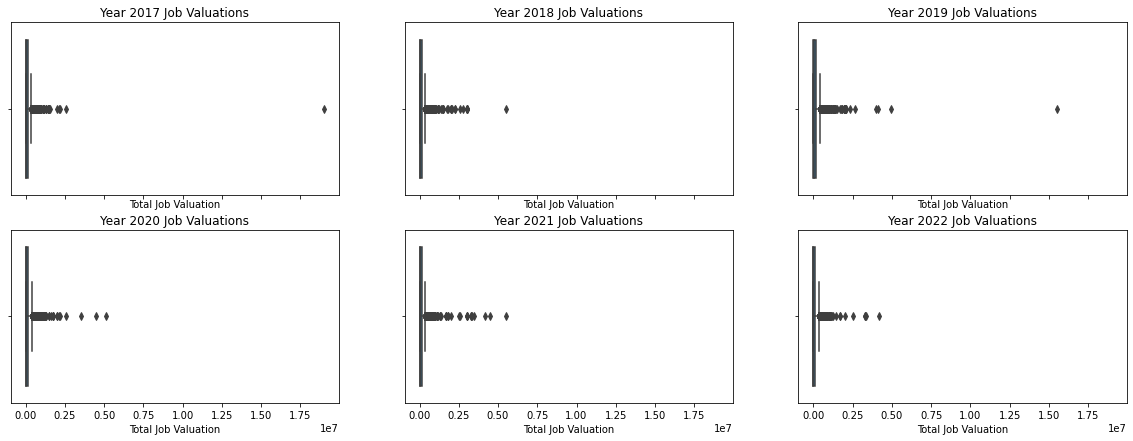

In [7]:
# Total Job Valuation Ranges
fig, axes = plt.subplots(2,3,figsize=(20,7),sharex=True)
data_2017 = data[data['Calendar Year Issued']==2017]
data_2018 = data[data['Calendar Year Issued']==2018]
data_2019 = data[data['Calendar Year Issued']==2019]
data_2020 = data[data['Calendar Year Issued']==2020]
data_2021 = data[data['Calendar Year Issued']==2021]
data_2022 = data[data['Calendar Year Issued']==2022]

# Plotting the box plot of each job valuation
sns.boxplot(data_2017['Total Job Valuation'], ax=axes[0,0])
axes[0,0].set_title('Year 2017 Job Valuations')
sns.boxplot(data_2018['Total Job Valuation'], ax=axes[0,1])
axes[0,1].set_title('Year 2018 Job Valuations')
sns.boxplot(data_2019['Total Job Valuation'], ax=axes[0,2])
axes[0,2].set_title('Year 2019 Job Valuations')
sns.boxplot(data_2020['Total Job Valuation'], ax=axes[1,0])
axes[1,0].set_title('Year 2020 Job Valuations')
sns.boxplot(data_2021['Total Job Valuation'], ax=axes[1,1])
axes[1,1].set_title('Year 2021 Job Valuations')
sns.boxplot(data_2022['Total Job Valuation'], ax=axes[1,2])
axes[1,2].set_title('Year 2022 Job Valuations')

There are definitely some jobs that would require some extra careful analyzing because in 2019 and 2017, there was a job where the job valuation estimate was approximately 17 million. That specific job would need to be analyzed to see if there are any indicators that would lead to that large amount of job valuation. Besides those two jobs, the overall range of job valuation is relatively the same. There has been an increase since 2017 where more and more jobs have been getting closer to the $0.75 * 10^7$ range. In 2017 the concentrated area is around $0.25 * 10^7$ whereas, in 2022, there are more jobs closer to $0.5 * 10^7$ range.

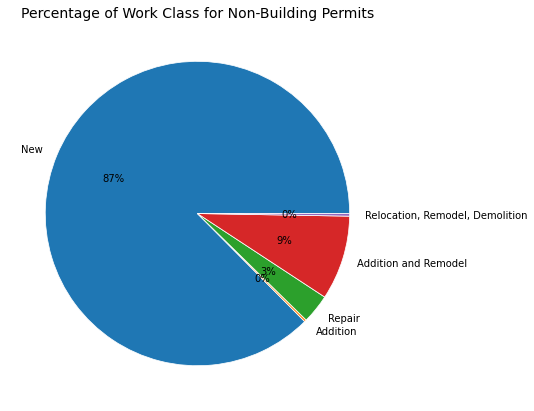

In [22]:
# Sorting the data to only New, Demolition, Repair, Addition and Remodel, Addition, Relocation and Remodel
data_new_work_class = data[data['Work Class']=='New']
data_demolition_work_class = data[data['Work Class']=='Demolition']
data_repair_work_class = data[data['Work Class']=='Repair']
data_addition_remodel_work_class = data[data['Work Class']=='Addition and Remodel']
data_addition_work_class = data[data['Work Class']=='Addition']
data_relocation_remodel_work_class = data[data['Work Class']=='Relocation and Remodel']

# Calculate the total job valuation for only those specific Work Class
new_total_valuation = sum(data_new_work_class['Total Job Valuation'])
demolition_total_valuation = sum(data_demolition_work_class['Total Job Valuation'])
repair_total_valuation = sum(data_repair_work_class['Total Job Valuation'])
addition_remodel_total_valuation = sum(data_addition_remodel_work_class['Total Job Valuation'])
addition_total_valuation = sum(data_addition_work_class['Total Job Valuation'])
relocation_remodel_total_valuation = sum(data_relocation_remodel_work_class['Total Job Valuation'])

valuation_data = sum([new_total_valuation,demolition_total_valuation, repair_total_valuation, 
    addition_remodel_total_valuation, addition_total_valuation,relocation_remodel_total_valuation])

valuation_data_df = [new_total_valuation/valuation_data, addition_total_valuation/valuation_data, repair_total_valuation/valuation_data, 
    addition_remodel_total_valuation/valuation_data, (demolition_total_valuation + relocation_remodel_total_valuation)/valuation_data]

labels = ['New', 'Addition', 'Repair', 'Addition and Remodel', 'Relocation, Remodel, Demolition']

# Plotting pie chart
plt.figure(figsize=(20,7))
c = sns.color_palette('pastel')[0:5]
plt.pie(valuation_data_df, labels = labels, autopct='%.0f%%', wedgeprops={'linewidth':0.75,'edgecolor':'white'})
plt.title('Percentage of Work Class for Non-Building Permits', fontdict={'fontsize':14})
fig.set_facecolor('white')

Principal Component Analysis
---
The target variable that is the Total Job Valuation because it represents the cost of the specific construction job. Out of the existing columns, only 12 were selected based on a quick examination of the columns and what the columns represent. For example, the Construction Permit Number would not have an influence to the Total Job Valuation. Some columns factors have been reduced because to perform a principal component analysis, there can not be any missing values and all the columns values need to be numerical. Due to this constraint, any row that has any missing entry within the columns of interest, was removed from the data set for PCA. The remaining data set had approximately 7000 rows of filled information. The data set was also converted from categorical data set to a numerical system. The columns that were converted were Permit Type, Permit Class, Permit Class Mapped, Work Class, Condominium, and Date Issued. After that, the entire data set was scaled to achieve an average value of 0 and a variance level of 1. For PCA, a total of four more data cleaning and preprocessing was conducted. One of that was making all of the empty spaces into NaN so they can be searched and deleted. One of it was deleting all of the NaN for all the rows where there are any NaN. Another operation that was done by converting all of the categorical data into numerical data. Finally, the last operation was to scale all the numerical values. 

In [23]:
# Choosing the columns
data_columns_for_pca = data[["Permit Type Desc", "Permit Class Mapped","Permit Class","Work Class", "Condominium", "Day Issued",
'Remodel Repair SQFT', 'Total New Add SQFT','Total Valuation Remodel', 'Number Of Floors', 'Total Job Valuation',
'Total Lot SQFT','Calendar Year Issued']]

#Replacing the empty space with NaN and then deleting all the NaN
data_columns_for_pca = data_columns_for_pca.replace(r'^s*$', float('NaN'))
data_columns_for_pca.dropna(inplace = True)

#Selecting the columns that are categorical and converting it into numerical 
cate_columns = data_columns_for_pca.select_dtypes(['object']).columns
data_columns_for_pca[cate_columns] = data_columns_for_pca[cate_columns].apply(lambda x: pd.factorize(x)[0])
data_target = data_columns_for_pca['Total Job Valuation']
data_columns_for_pca.drop(columns='Total Job Valuation', inplace=True)

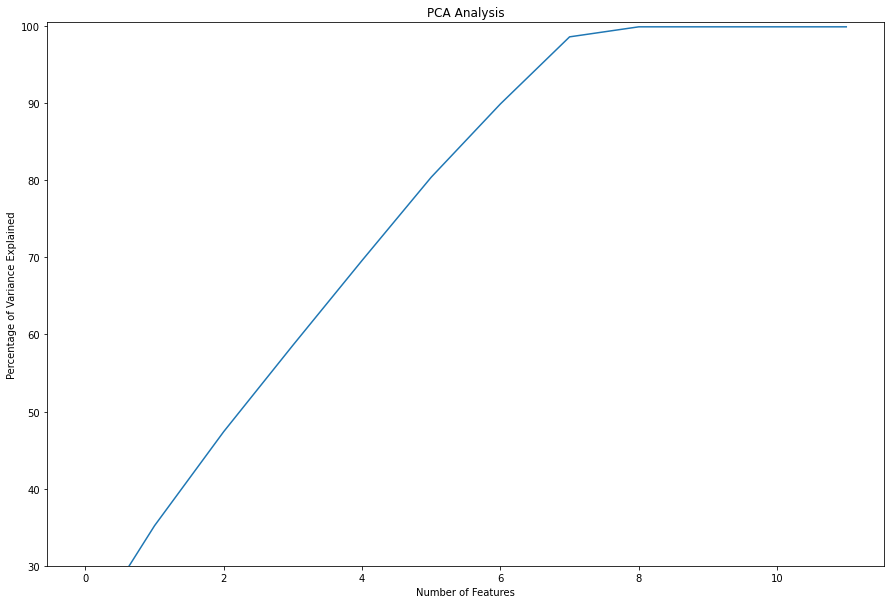

In [24]:
#Standardizing the data set
data_frame_standarized = StandardScaler().fit_transform(data_columns_for_pca)

# Performing the PCA
pca_construction = PCA(n_components = 12)
pca_components = pca_construction.fit_transform(data_frame_standarized)

# Plotting the PCs
explained_variance_rounded=np.cumsum(np.round(pca_construction.explained_variance_ratio_, decimals=3)*100)
plt.figure(figsize=(15,10))
plt.ylabel('Percentage of Variance Explained')
plt.xlabel('Number of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.plot(explained_variance_rounded)

Results of PCA
---
According to the PCA we would need approximately 7 features of the original 12 because 95% of the variance will be covered. This analysis is important because it will help us determine what is the minimum amount of features necessary to still capture a large amount of the variance. PCA's main usage is for the reduction of dimensionality which for this specific data set is important because there are many columns with sometimes no influence. 

<AxesSubplot:>

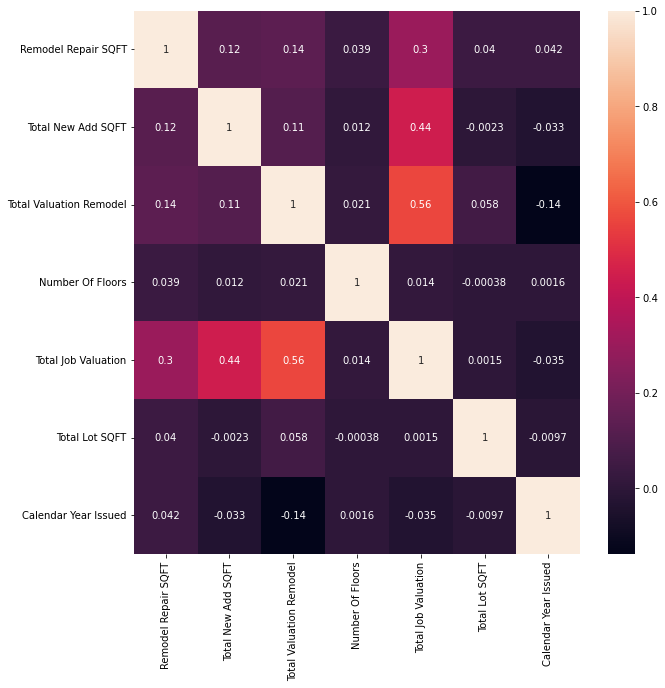

In [27]:
data_columns_for_pca = data[["Permit Type Desc", "Permit Class Mapped","Permit Class","Work Class", "Condominium", "Day Issued",
'Remodel Repair SQFT', 'Total New Add SQFT','Total Valuation Remodel', 'Number Of Floors', 'Total Job Valuation',
'Total Lot SQFT','Calendar Year Issued']]

matrix = data_columns_for_pca.corr()
plt.figure(figsize=(10,10))
sns.heatmap(matrix, annot=True)

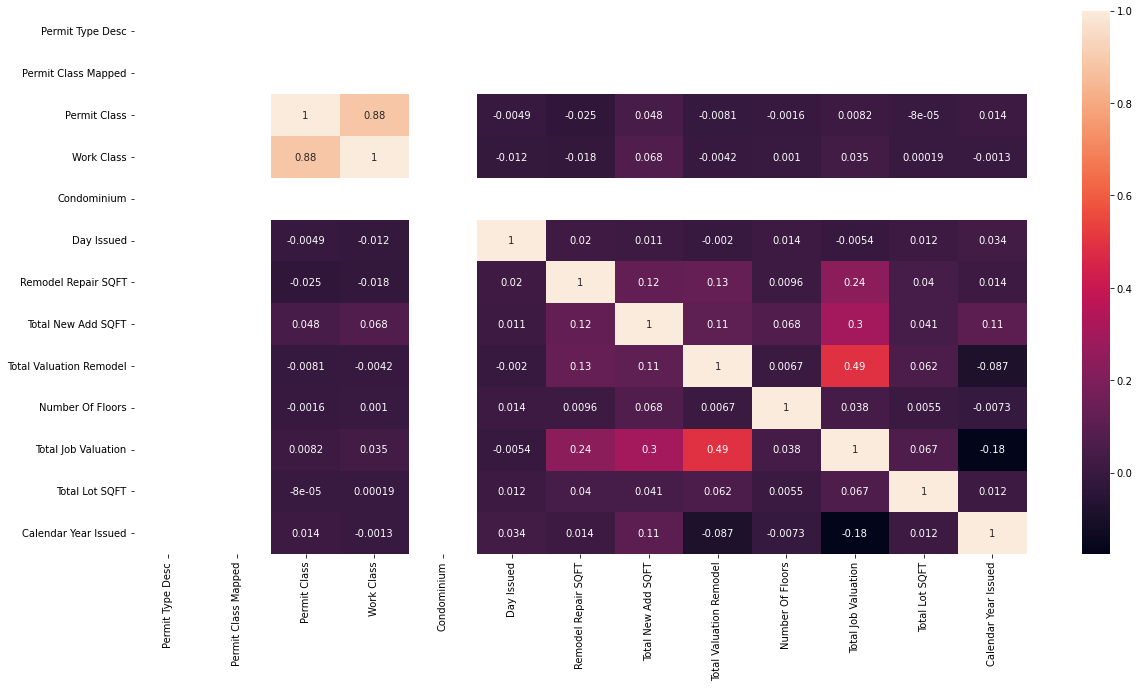

In [28]:
plt.figure(figsize=(20,10))

data_columns_for_pca = data[["Permit Type Desc", "Permit Class Mapped","Permit Class","Work Class", "Condominium", "Day Issued",
'Remodel Repair SQFT', 'Total New Add SQFT','Total Valuation Remodel', 'Number Of Floors', 'Total Job Valuation',
'Total Lot SQFT','Calendar Year Issued']]

#Replacing the empty space with NaN and then deleting all the NaN
data_columns_for_pca = data_columns_for_pca.replace(r'^s*$', float('NaN'))
data_columns_for_pca.dropna(inplace = True)
cate_columns = data_columns_for_pca.select_dtypes(['object']).columns
data_columns_for_pca[cate_columns] = data_columns_for_pca[cate_columns].apply(lambda x: pd.factorize(x)[0])
matrix = data_columns_for_pca.corr()
sns.heatmap(matrix, annot=True)

#sns.heatmap(.componepca_constructionnts_, annot=True, xticklabels=data_columns_for_pca.columns, yticklabels=data_columns_for_pca.columns)
plt.show()

The heatmap is very messy and difficult to understand. This might be contributed to the fact that there were standardization of categorical data columns into numerical data columns. However, there are some areas where it does make sense. For example, Permit Class and Work Class is related  to Permit Type Desc. Something that is interesting is that the Condominium is almost negatively influencing the Number of Floors which makes sense because a condominium only has 1 floor and it does not increase at all. Ideally, this heatmap will show the interconnectivity between the features and allow us to reduce features even more. The reasoning is that multicollinearity can be seen through the heatmap which allows us to see whether some features are closely related to other features. If they are, the amount of features can be reduced.

In [30]:
from pickle import TRUE
import pandas as pd
import plotly.express as px
lat_foc = data['Latitude'][0]
lon_foc = data['Longitude'][0]
fig = px.scatter_geo(data, lat='Latitude', lon='Longitude', hover_name="Total Job Valuation")
fig.update_layout(geo = dict(
            projection_scale=100, 
            center=dict(lat=lat_foc, lon=lon_foc),
            scope='usa'
        ))
fig.show()

This specific scatter plot for geo location gives us a brief image on where the majority of construction permit jobs are located at. As expected, majority of the jobs are within the center of the Austin, TX with some scattered areas of concentration outwards of the inner city. A future item to display would be the specific shapefile of Austin, TX so that way we are able to see more clearly on how the specific cost of the job could relate to how close it is to the inner city. There will be more items to explore. 

**Phase 2:** Deliverables
---
1. Algorithms/Visualizations: Apply 5 different significant and relevant
algorithms (ML, MR, and/or statistical models) to your data and create visualizations for
the results. 
    - For 487 students: at least 1 of the 5 algorithms must be one that was not
discussed in class. 
    - For 587 students: at least 2 must be from outside of class. 
    - These outside algorithms can come from the class textbooks, or other sources. Cite the appropriate sources for each outside algorithm you choose to apply.
2. Explanation and Analysis: For each of the 5 above algorithms, provide
justification for why you chose the particular algorithm, and discuss the effectiveness of
the algorithm when applied to your data to answer questions related to your problem
statement. 
    - This should include discussion of any relevant metrics for demonstrating
model effectiveness, as well as any intelligence you were able to gain from application of
the algorithm to your data.

*Note: Disregarding driveway/sidewalks*

Word Count
---

In [34]:
'''
Word Count Function
Input: text -> String
Output: Counter[String -> Int]
Returns a dictionary containing word counts
'''
def wc(text):
    words = re.findall("[a-z']+", text.lower().replace("<br />", ""))
    return Counter(words)

data['word_counts'] = data['Description'].astype(str).replace('\d+','').map(wc)
data['word_counts']

0        {'this': 1, 'is': 1, 'the': 1, 'accessory': 1,...
1        {'inground': 1, 'swimming': 1, 'pool': 1, 'and...
2        {'new': 1, 'story': 1, 'singlefamily': 1, 'res...
3        {'addition': 1, 'of': 1, 'a': 1, 'new': 1, 'de...
4        {'addition': 1, 'to': 1, 'add': 2, 'sf': 1, 'c...
                               ...                        
55971    {'express': 1, 'patio': 1, 'doors': 1, 'and': ...
55972    {'new': 1, 'inground': 1, 'swimming': 1, 'pool...
55973    {'cr': 1, 'new': 1, 'story': 1, 'bedroom': 1, ...
55974         {'express': 1, 'foundation': 1, 'repair': 1}
55975    {'sqft': 2, 'pool': 1, 'w': 1, 'stepping': 1, ...
Name: word_counts, Length: 55976, dtype: object

In [33]:
data['Total New Add SQFT'] = data['Total New Add SQFT'].fillna(0)

K-Means
---
Before starting with the k-Means clustering, we will first use an elbow curve to determine the optimal value for k.

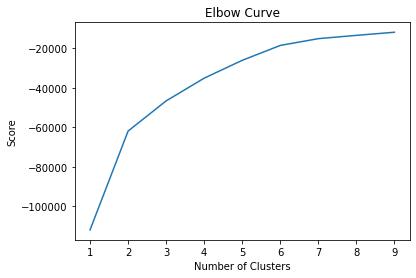

In [35]:
scaler = StandardScaler()
scaled_kmeans = pd.DataFrame(scaler.fit_transform(data[["Total New Add SQFT", "Total Job Valuation"]]),columns=["Total New Add SQFT","Total Job Valuation"])

Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(scaled_kmeans).score(scaled_kmeans) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

The slope of the curve is the greatest for the first 2 values of k but significantly reduces as k increases. We will be using $k=6$ as afterwards there are minimal increases in accuracy.

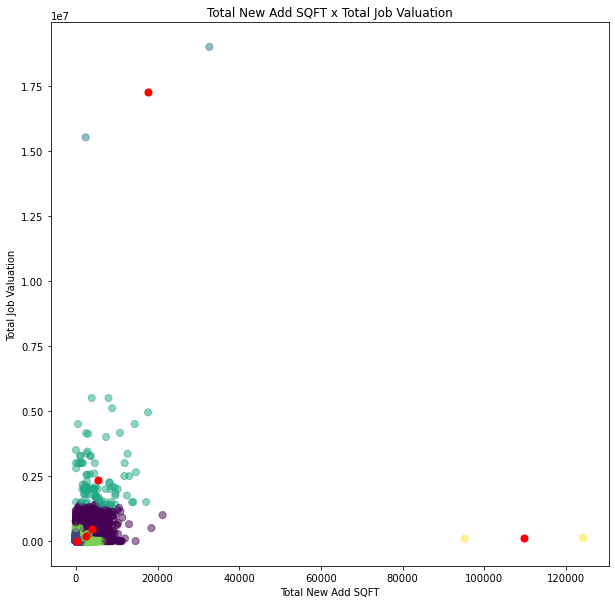

In [38]:
kmeans = KMeans(n_clusters = 6).fit(scaled_kmeans)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.figure(figsize=(10,10))
plt.xlabel('Total New Add SQFT')
plt.ylabel('Total Job Valuation')
plt.title('Total New Add SQFT x Total Job Valuation')
plt.scatter(data["Total New Add SQFT"], data["Total Job Valuation"], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:,0], centroids[:,1], c='red', s=50)

As shown above, there are several outliers leaving inconsistencies. The cluster centroids for the yellow patch, along with the two on the top left and bottom right have too much of a gap between the clusters. To more accurately depict the results of k-Means, we will only work with data within 3 standard deviations.

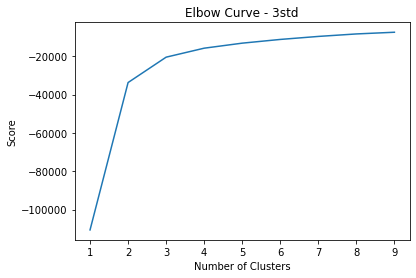

In [39]:
data_3std = data[(np.abs(stats.zscore(data[["Total New Add SQFT", "Total Job Valuation"]])) < 3).all(axis=1)]
scaled_kmeans = pd.DataFrame(scaler.fit_transform(data_3std[["Total New Add SQFT", "Total Job Valuation"]]),columns=["Total New Add SQFT","Total Job Valuation"])
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(scaled_kmeans).score(scaled_kmeans) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve - 3std')
plt.show()

We will assign out k value to be 4 as this is the last instance of any noticable growth in the slope.

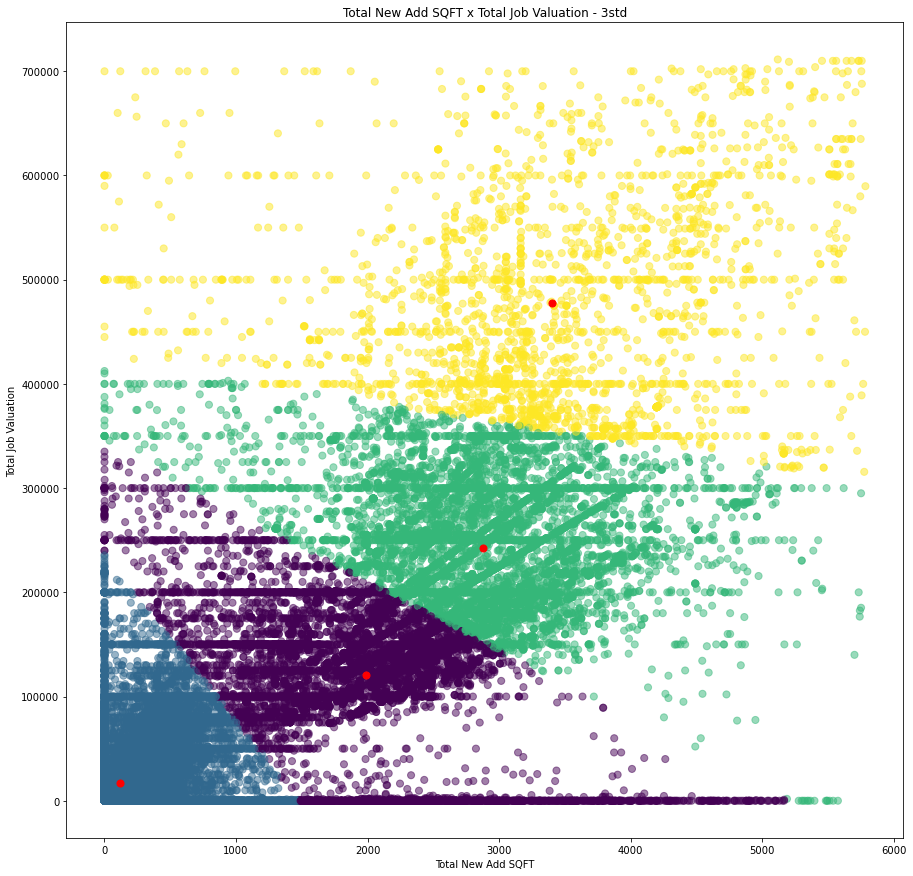

In [41]:
kmeans = KMeans(n_clusters = 4).fit(scaled_kmeans)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.figure(figsize=(15,15))
plt.xlabel('Total New Add SQFT')
plt.ylabel('Total Job Valuation')
plt.title('Total New Add SQFT x Total Job Valuation - 3std')
plt.scatter(data_3std["Total New Add SQFT"], data_3std["Total Job Valuation"], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:,0], centroids[:,1], c='red', s=50)

With this, we can determine a more appropriate class using the boundary conditions shown by the clustering groups.

K-NN
---
Similar to the approach with k-Means, we will first see the accuracy of the classification model.

In [42]:
x = data_3std["Total New Add SQFT"].values.reshape(-1, 1)
y = data_3std["Total Job Valuation"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

classifier = KNeighborsClassifier()
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
classifier.score(x_test, y_test)

0.1555877034358047

The accuracy of this current model is inefficient. However, we wish to find the correlation between SQFT and Total Job Valuation from our finding from the heatmap produced from Phase 1. What if we change our k value?

Text(0.5, 0, 'Number of Neighbors')

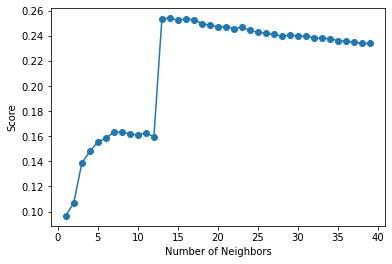

In [43]:
acc=[]
for i in range(1,40):
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(x_train, y_train)
    acc.append(classifier.score(x_test, y_test))
plt.plot(range(1,40), acc, marker='o')
plt.ylabel('Score')
plt.xlabel('Number of Neighbors')

There is a substantial increase in accuracy between the k values [2,3] and [12,13]. Regardless, k-NN would not be the best model for our purpose as the highest score achieved is 0.25, which is still not enough.

Linear Regression
---
We will continue using our data within 3 standard deviations for our linear regression model.

In [45]:
data_3std = data[(np.abs(stats.zscore(data[["Total New Add SQFT", "Total Job Valuation"]])) < 3)]
data_3std['Permit Class'] = data['Permit Class']
# Dropping N/A values increased R^2 by 0.05
data_3std = data_3std.dropna(subset=["Total New Add SQFT", "Total Job Valuation"])

x = data_3std[["Total New Add SQFT"]]
y = data_3std["Total Job Valuation"]
 
# sklearn Lin Regr
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# Adding a constant using statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)


Intercept: 
 14554.197826528136
Coefficients: 
 [73.621317]
                             OLS Regression Results                            
Dep. Variable:     Total Job Valuation   R-squared:                       0.602
Model:                             OLS   Adj. R-squared:                  0.602
Method:                  Least Squares   F-statistic:                 8.365e+04
Date:                 Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                         16:09:56   Log-Likelihood:            -7.0145e+05
No. Observations:                55298   AIC:                         1.403e+06
Df Residuals:                    55296   BIC:                         1.403e+06
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

c:\Users\josep\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



One of the algorithms that is being used outside of class is Random Forest machine learning algorithm. We are also incorporating Bagging ensembler learning which is basically randomly splitting the data set into different versions with different entries selected and from there, the Random Forest is created through the best model of all the occurrences. That way, it will optimize the model to better predict the values. We wanted to use regular Decision Tree Regressors in the beginning; however, Random Forest Regressor was used in the end because Decision Trees tend to get overfitted quite easily so we wanted to apply Bagging to counteract that as well as including a training and testing portion. 

- [Link 1 - Random Forest Model](https://medium.com/nerd-for-techbootstrap-aggregating-and-random-forest-model-9460e235537)
- [Link 2 - Random Forest Regression](https://www.geeksforgeeks.org/random-forest-regression-in-python/)
- [Link 3 - Sklearn Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)


In [47]:
# Choosing the columns
data_columns_for_pca = data[[
'Remodel Repair SQFT', 'Total New Add SQFT','Total Valuation Remodel', 'Number Of Floors', 'Total Job Valuation',
'Total Lot SQFT']]

# Replacing the empty space with NaN and then deleting all the NaN
data_columns_for_pca = data_columns_for_pca.replace(r'^s*$', float('NaN'))
data_columns_for_pca.dropna(inplace = True)
print(data_columns_for_pca.shape)

# Removing some job valuation that is less than 1000
data_columns_for_pca = data_columns_for_pca[data_columns_for_pca['Total Job Valuation']>1000]
print(data_columns_for_pca.shape)

# Saving the Total Job Valuation for future use and removing it for training models
data_target = data_columns_for_pca['Total Job Valuation']
data_columns_for_pca.drop(columns='Total Job Valuation', inplace=True)

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(data_columns_for_pca, data_target, test_size=0.2, train_size=0.8)

(6819, 6)
(3870, 6)


[Text(787.9166666666666, 978.48, 'X[0] <= 5380.0\nmse = 34371695442.994\nsamples = 3096\nvalue = 105448.597'),
 Text(413.3333333333333, 761.0400000000001, 'X[1] <= 882.5\nmse = 19075877413.077\nsamples = 3072\nvalue = 97593.143'),
 Text(206.66666666666666, 543.6, 'X[2] <= 181066.5\nmse = 9240387856.047\nsamples = 2586\nvalue = 72220.837'),
 Text(103.33333333333333, 326.1600000000001, 'X[0] <= 645.0\nmse = 7494842765.559\nsamples = 2528\nvalue = 66427.857'),
 Text(51.666666666666664, 108.72000000000003, 'mse = 3000772899.319\nsamples = 1705\nvalue = 46119.416'),
 Text(155.0, 108.72000000000003, 'mse = 14180607154.581\nsamples = 823\nvalue = 108500.628'),
 Text(310.0, 326.1600000000001, 'X[2] <= 412500.0\nmse = 20106151686.774\nsamples = 58\nvalue = 324714.862'),
 Text(258.3333333333333, 108.72000000000003, 'mse = 7411918402.702\nsamples = 50\nvalue = 291469.24'),
 Text(361.66666666666663, 108.72000000000003, 'mse = 49362500000.0\nsamples = 8\nvalue = 532500.0'),
 Text(620.0, 543.6, 'X[2

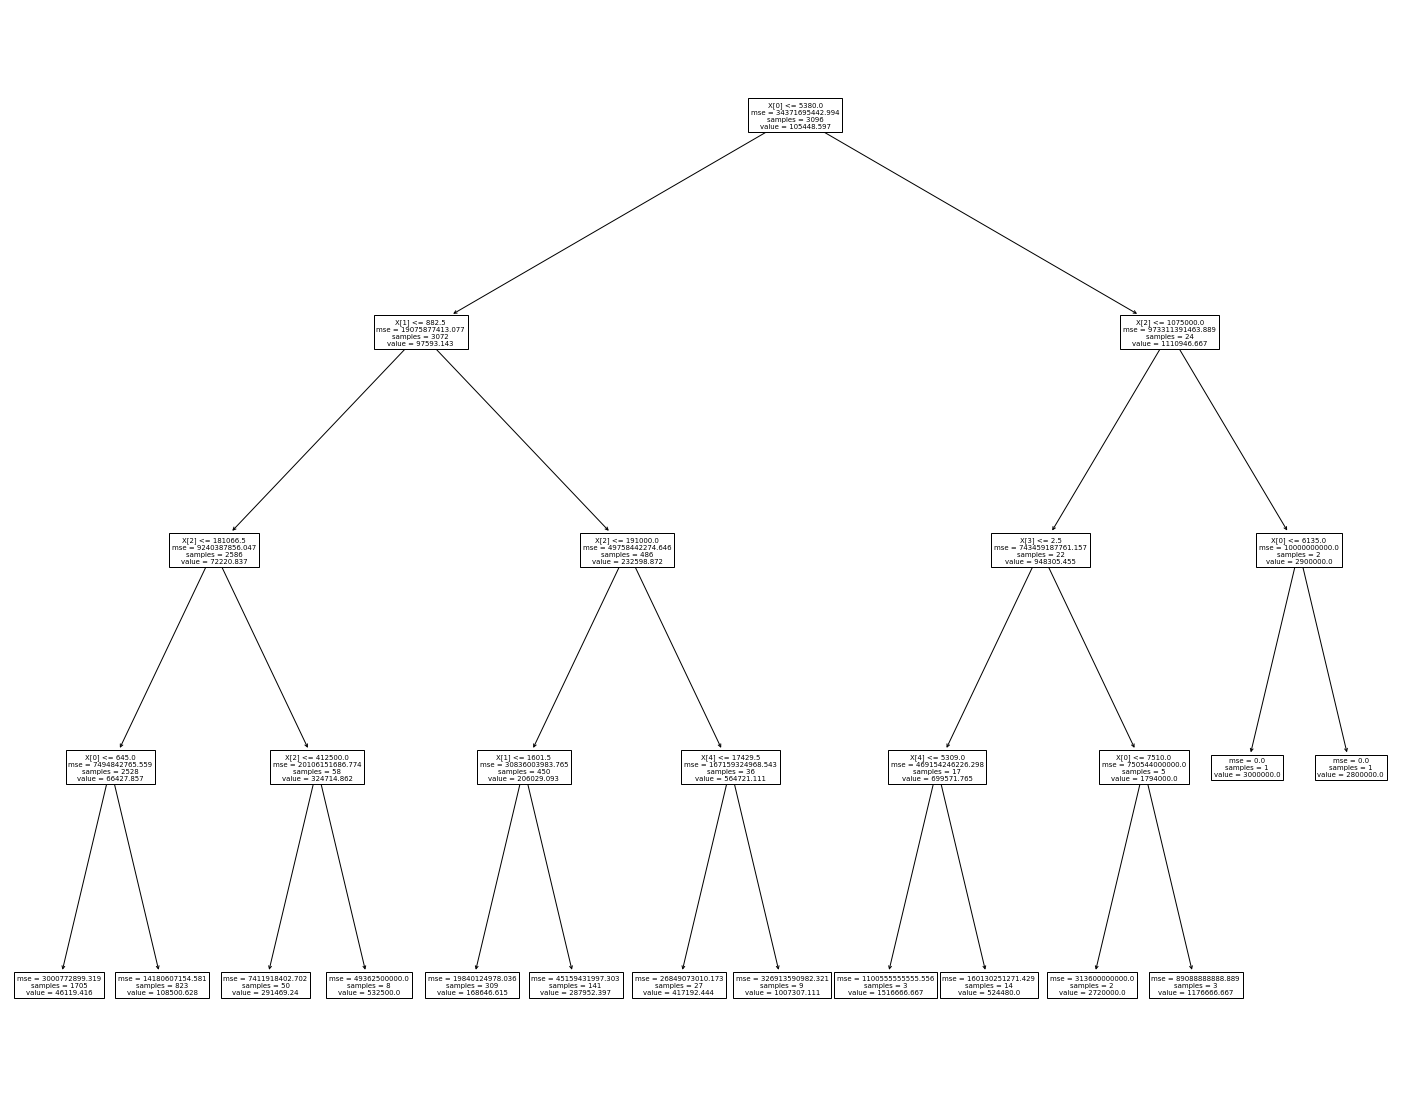

In [48]:
# Created a max depth decision tree, by limiting the depth it will prevent overfitting
dt_max5 = DecisionTreeRegressor(max_depth=4)
dt_max5.fit(X_train_dt, y_train_dt)

#Calculates the prediction amount and plots the tree
y_dt_max5 = dt_max5.predict(X_test_dt)
plt.figure(figsize=(25,20))
tree.plot_tree(dt_max5)

In [49]:
#Calculates all the necessary metrics of the decision tree
mae_dt = metrics.mean_absolute_error(y_test_dt, y_dt_max5)
mse_dt = metrics.mean_squared_error(y_test_dt, y_dt_max5)
rmse_dt = np.sqrt(mse_dt) # or mse**(0.5)  
r2_dt = metrics.r2_score(y_test_dt,y_dt_max5)
r2_dt

0.2813738461950984

Text(0.5, 1.0, 'Feature Importance Decision Tree (MDI)')

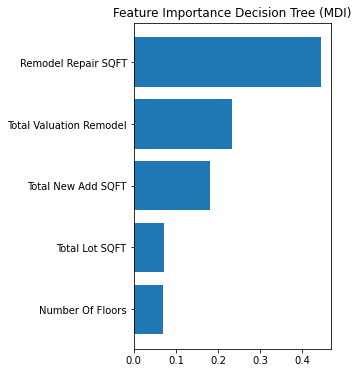

In [50]:
# Plot the features of importance for future cases of either reducing features or inputting features that have correlation to improve the model
feature_importance = dt_max5.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(data_columns_for_pca.columns)[sorted_idx])
plt.title("Feature Importance Decision Tree (MDI)")

It can be seen that for Decision Tree, the remodel repair SQFT holds the most amount of influence to the job valuation. Something that was quite surprisingly would be why Total Lot SQFT is among the least influential because with more area, there would be material and labor needed to do the remodeling which means higher in price valuation. 

In [54]:
# Created a Random Forest model with specific criterion to be MSE with a max depth of 5 levels for the forest
rf_regression = RandomForestRegressor(bootstrap=True, max_depth=5, criterion="mse") # was 'squared_error', changed to 'mse' to run it for Seungmin's ver
rf_regression.fit(X_train_dt, y_train_dt)

filename = 'random_forest.sav'
# Saved best working model
# pickle.dump(rf_regression, open(filename, 'wb'))
y_rf_max4 = rf_regression.predict(X_test_dt)

[Text(904.5703125, 996.6, 'X[0] <= 5389.5\nmse = 40746309330.003\nsamples = 1947\nvalue = 105767.836'),
 Text(588.515625, 815.4000000000001, 'X[2] <= 206500.0\nmse = 15615628556.367\nsamples = 1934\nvalue = 94394.425'),
 Text(348.75, 634.2, 'X[1] <= 728.5\nmse = 11097902093.757\nsamples = 1888\nvalue = 85540.599'),
 Text(174.375, 453.0, 'X[0] <= 645.0\nmse = 5835619817.603\nsamples = 1527\nvalue = 62864.648'),
 Text(87.1875, 271.79999999999995, 'X[2] <= 60125.0\nmse = 3164182546.664\nsamples = 1036\nvalue = 45227.988'),
 Text(43.59375, 90.59999999999991, 'mse = 2913245109.145\nsamples = 996\nvalue = 41809.368'),
 Text(130.78125, 90.59999999999991, 'mse = 2403542388.782\nsamples = 40\nvalue = 124774.687'),
 Text(261.5625, 271.79999999999995, 'X[3] <= 3.5\nmse = 9320434519.346\nsamples = 491\nvalue = 98268.611'),
 Text(217.96875, 90.59999999999991, 'mse = 7962973738.794\nsamples = 490\nvalue = 96968.572'),
 Text(305.15625, 90.59999999999991, 'mse = 0.0\nsamples = 1\nvalue = 1150000.0'),


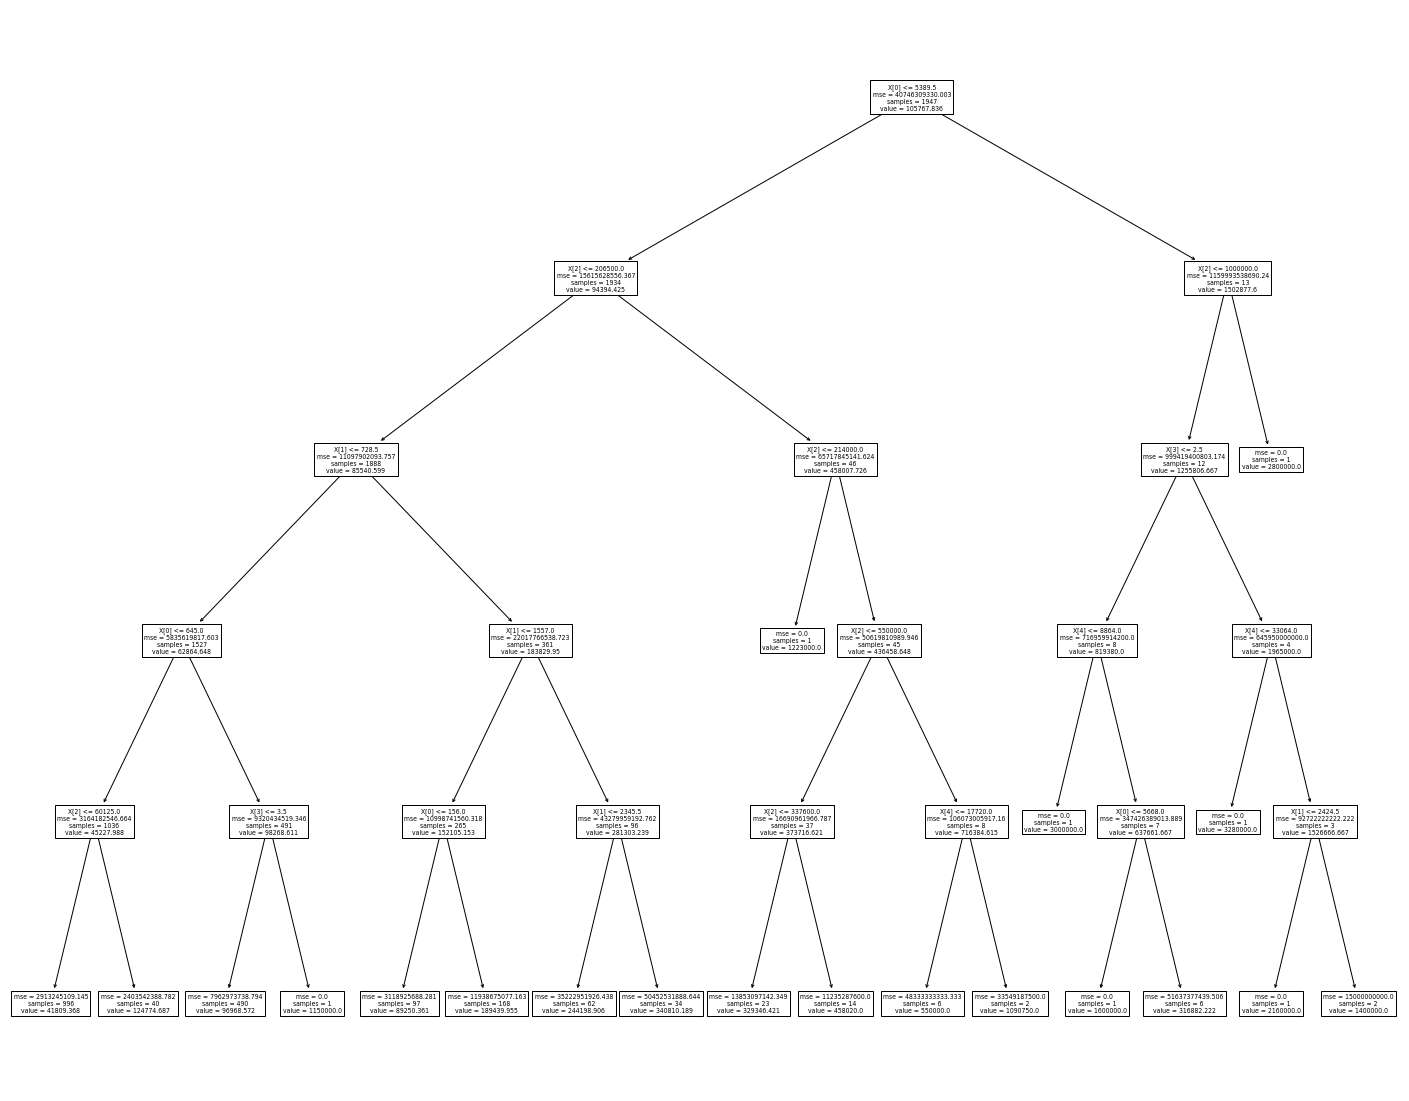

In [55]:
# Plots the random forest
plt.figure(figsize=(25,20))
tree.plot_tree(rf_regression.estimators_[0])

In [56]:
# Calculates the metrics for this Random Forest
mae_rf = metrics.mean_absolute_error(y_test_dt, y_rf_max4)
mse_rf = metrics.mean_squared_error(y_test_dt, y_rf_max4)
rmse_rf = np.sqrt(mse_rf) # or mse**(0.5)  
r2_rf = metrics.r2_score(y_test_dt,y_rf_max4)
r2_rf

0.2982087078966893

Through testing the different parameters and testing the training data set, the R2 values changes very frequently. On some occasions the R2 values would reach approximately 60%. That specific model was saved and placed into the Phase 3 folder so that way we can exchange models if a better model comes out and for it to be used in the front end calculations.  

Text(0.5, 1.0, 'Random Forest (MDI)')

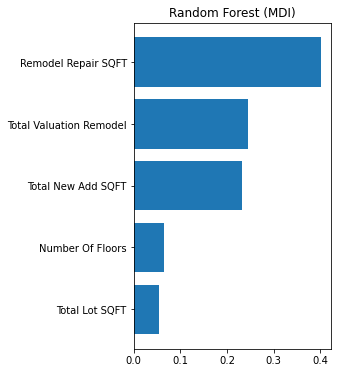

In [57]:
# Plotting the differet in feature importance. Shows relatively same information as Decision Tree which is not surprising
feature_importance = rf_regression.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(data_columns_for_pca.columns)[sorted_idx])
plt.title("Random Forest (MDI)")

In [59]:
# Constructs a Boosting algorithm tree
gb_max = GradientBoostingRegressor(criterion="mse") # 'squared_error' => 'mse'
gb_max.fit(X_train_dt, y_train_dt)

# Saved best working model
# filename = 'GradientBoosting.sav'
# pickle.dump(gb_max, open(filename, 'wb'))

y_gb_max = gb_max.predict(X_test_dt)
plt.figure(figsize=(25,20))

mae_gb = metrics.mean_absolute_error(y_test_dt, y_gb_max)
mse_gb = metrics.mean_squared_error(y_test_dt, y_gb_max)
rmse_gb = np.sqrt(mse_gb) # or mse**(0.5)  
r2_gb = metrics.r2_score(y_test_dt,y_gb_max)
r2_gb

0.2931994757746075

<Figure size 1800x1440 with 0 Axes>

The best model between Random Forest and Gradient Boosting sometimes changes depending on the random state of the training and testing data set. There seems to be some incidents where Gradient Boosting performs better and other times, the Random Forest performs better. 

Text(0.5, 1.0, 'Gradient Boosting (MDI)')

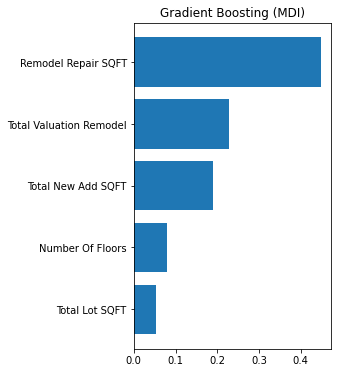

In [60]:
feature_importance = gb_max.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(data_columns_for_pca.columns)[sorted_idx])
plt.title("Gradient Boosting (MDI)")

# This figure is representing the features of importance to the Gradient boosting model

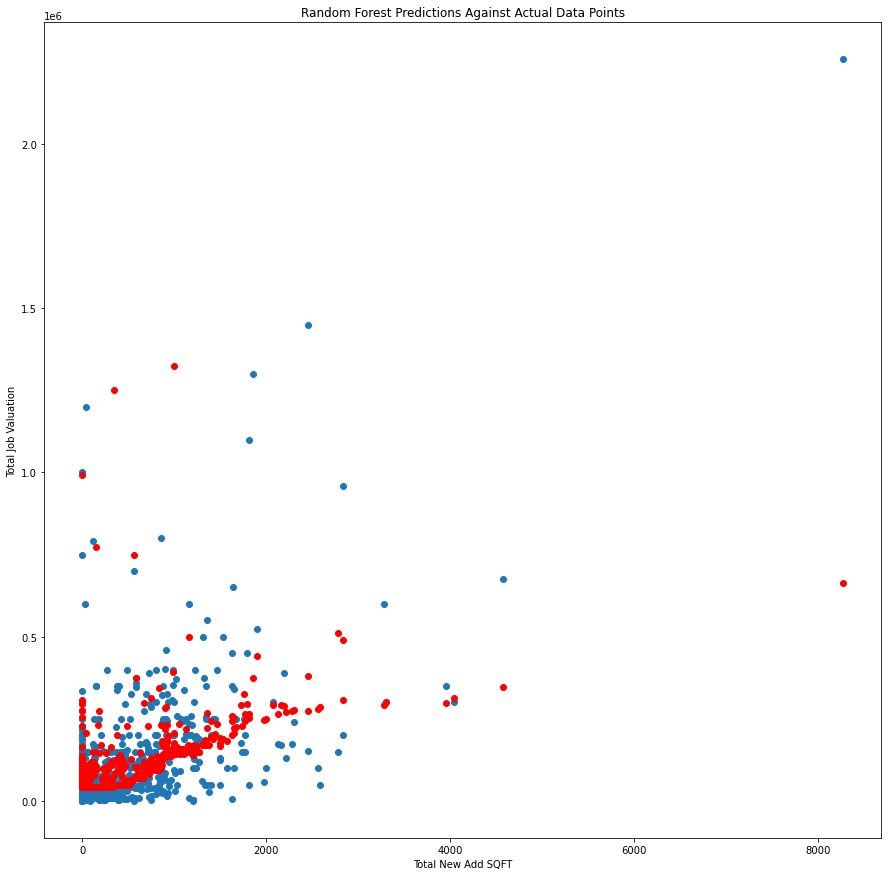

In [62]:
# This is the plot of the random forest results and the original data points. 
plt.figure(figsize=(15,15))
plt.xlabel('Total New Add SQFT')
plt.ylabel('Total Job Valuation')
plt.title('Random Forest Predictions Against Actual Data Points')
plt.scatter(X_test_dt.loc[:,"Total New Add SQFT"], y_test_dt)
plt.scatter(X_test_dt.loc[:,"Total New Add SQFT"], y_rf_max4, color="red")

Text(0.5, 1.0, 'RMSE vs MAE')

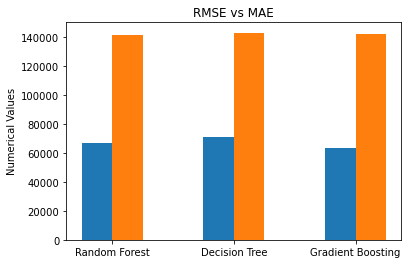

In [63]:
# Allows a better way to portray the information through graphing
mae_comparison = [mae_rf, mae_dt, mae_gb]
mse_comparison = [mse_rf, mse_dt, mse_gb]
rmse_comparison = [rmse_rf, rmse_dt, rmse_gb]
r2_comparison = [r2_rf, r2_dt, r2_gb]

width = 0.25

labels = ["Random Forest", "Decision Tree", "Gradient Boosting"]
x_labels = np.arange(len(labels))
plt.bar(x_labels - 0.125, mae_comparison, width=width)
plt.bar(x_labels + 0.125, rmse_comparison, width=width)
plt.xticks(x_labels, labels)
plt.ylabel("Numerical Values")
plt.title("RMSE vs MAE")

# RMSE is highest one
# Notation here: the MSE values are wayyyyy tooo high! Unable to portray it on the same graph!

Text(0.5, 1.0, 'R2 Comparison')

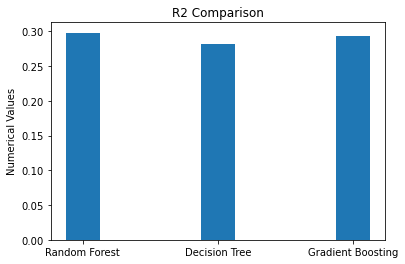

In [64]:
# Shows the comparison between the R2 values for all three models
# This graph changes but Decison Tree almost never makes it to the best model 
labels = ["Random Forest", "Decision Tree", "Gradient Boosting"]
x_labels = np.arange(len(labels))
plt.bar(x_labels, r2_comparison, width=width)
plt.xticks(x_labels, labels)
plt.ylabel("Numerical Values")
plt.title("R2 Comparison")

In [65]:
# Another way for easier comparison between the models metrics
print("Results of sklearn.metrics for Decision Tree:")
print("MAE for Decision Tree:", mae_dt)
print("MSE for Decision Tree:", mse_dt)
print("RMSE for Decision Tree:", rmse_dt)
print("R-Squared for Decision Tree:", r2_dt)
print("")
print("Results of sklearn.metrics for Random Forest:")
print("MAE for Random Forest:", mae_rf)
print("MSE for Random Forest:", mse_rf)
print("RMSE for Random Forest:", rmse_rf)
print("R-Squared for Random Forest:", r2_rf)
print("")
print("Results of sklearn.metrics for Gradient Boosting:")
print("MAE for Gradient Boosting:", mae_gb)
print("MSE for Gradient Boosting:", mse_gb)
print("RMSE for Gradient Boosting:", rmse_gb)
print("R-Squared for Gradient Boosting:", r2_gb)

Results of sklearn.metrics for Decision Tree:
MAE for Decision Tree: 71134.64970839533
MSE for Decision Tree: 20520988401.695705
RMSE for Decision Tree: 143251.48656016
R-Squared for Decision Tree: 0.2813738461950984

Results of sklearn.metrics for Random Forest:
MAE for Random Forest: 66821.44720861252
MSE for Random Forest: 20040254434.676346
RMSE for Random Forest: 141563.60561484843
R-Squared for Random Forest: 0.2982087078966893

Results of sklearn.metrics for Gradient Boosting:
MAE for Gradient Boosting: 63526.12678914713
MSE for Gradient Boosting: 20183297369.774628
RMSE for Gradient Boosting: 142067.93223586606
R-Squared for Gradient Boosting: 0.2931994757746075


In the end for Phase 2, the models that were saved and used for the data product were models that had the highest R2 values. The reasoning is because we would like to cover as much of the variance as possible and the R2 value represents that. There is a similar trend where when the R2 values is the highest, the MSE values are also the lowest which makes sense because with the variance covered more, the model would be able to predict more accurately, which means that the error would decrease. In the end, for Phase 3, we chose the random forest model and the linear regression model. The reason is because the linear regression model is very easy to understand, when the variable increases, the job would increase at a relevant rate. The random forest model is more difficult to interpret but it allows other factors to influence and predict the cost. The linear regression model would rise too quickly but the random forest model would raise more slowly because of the addition information. Normally, for smaller total added SQFT, the random forest would predict a higher price but when it goes to a larger value, the linear regression model would be much higher. Both models performs well in terms of R2 value with the linear regression model being represented as an equation that is plugged into the front end whereas, the random forest model is saved and then used to predict the values. 

**Phase 3:** Deliverables
---
1. Code [25 marks]: In your submission you must include complete code for Phases 1-3, fully documented, and with clear and succinct instructions on how to run your code with different datasets. The report should contain any relevant notes on how your models are tuned/evaluated (ie: p value is 0.0006 etc), and any recommendations related to your problem statement based on your analysis. 
    - [5 marks] for fully documented code and working instructions to demo/use your finished product 
    - [10 marks] for relevant notes on how you specifically used the models from phase 2 (which models did your product end up using, tuning of any relevant parameters, etc) 
    - [10 marks] for recommendations related to your problem statement based on your analysis (what can users learn from your product, how does it help them solve problems related to your problem statement, other ideas for how to extend your project, or other avenues that could be explored related to the problem) 


2. Demo [25 marks]: In addition to your code, submit a short video pitch/presentation (no more than 5 minutes in length), giving a brief demo of your product, how it is used, and what information people can learn from it. 
    - [5 points] for showing a working user-interface (not just code you would expect a user to run) 
    - [5 points] for showing how a user could input their own data (uploading their own datasets, filling out fields in your GUI, etc) 
    - [15 points] for showing the feedback your product gives, explaining what it means, relevant manipulation/filtering of visualizations, and how a user could use it to help them solve a problem/answer a question.

ReadMe Page for FrontEnd UI Usage
---
Please run the cell with Flask. Everything is built within the cell and all the models are saved from Phase 2. A browser would be open automatically, referencing the StackOverFlow page included in the references. 

Once the browser is open, there will be 5 inputs for the form. Currently, if `Total Newly Added SQFT` is empty, then the page would be redirected back and not progress further. If all variables are filled, there will be a slight delay before redirecting to the prediction page citing the linear regression and random forest regression models. If only `Total Newly Added SQFT` is filled, then the linear regression prediction would be produced but the random forest regression model will show `More Variables Needed`. Once you're in the prediction page, there will be a back button that allows you to return back to the front page. 

The prediction page will show the model summary about linear regression and will show the accuracy of the testing data set for both random forest and linear regression model. Linear regression model was added because it is the simplest regression model to intrepret and when running the model with multiple features, all other featuers besides `Total Newly Added SQFT` had coefficients of zeros. 

References for FrontEnd UI Development
- [What is Flask Python - pythonbasics.org](https://pythonbasics.org/what-is-flask-python/)
- [Flask - askpython.org](https://www.askpython.com/python-modules/flask/flask-forms)
- [Flask Intro - pythongeeks.org](https://pythongeeks.org/python-flask-introduction/)
- [Flask, Ignoring Redirect Requests - stackoverflow](https://stackoverflow.com/questions/54448545/passing-information-from-one-route-to-another-flask-ignoring-redirect-requests)
- [Machine Learning with Flask - freecodecamp.org](https://www.freecodecamp.org/news/machine-learning-web-app-with-flask/)
- [JS Alert After Form Submission - stackoverflow](https://stackoverflow.com/questions/63931859/javascript-alert-after-submitting-a-form)
- [Browser Auto Open - stackoverflow](https://stackoverflow.com/questions/54235347/open-browser-automatically-when-python-code-is-executed)

In [ ]:
# Function to auto start and open the web browser when this cell is ran
def open_browser():
    webbrowser.open_new("http://127.0.0.1:5000")

# This function presents the linear regression equation associated with the linear regression model 
# to predict the job value with the total newly added SQFT
def making_Predictions_LR(totalSQFT):
    job_value = 17628.368810532556 + float(totalSQFT) * 70.15563012
    return '$' + str(round(job_value,2))

# This function takes all the variables from the inputted amounts and make a random forest prediction for those values
# The model is already trained using the previous data set
def making_Predictions_RF(totalSQFT, remodelRepair, totalValuationRemodel, numOfFloors, totalLotSqft):
    filename = 'random_forest.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    dataframe_making = {
    "Remodel Repair SQFT" : [remodelRepair],
    "Total New Add SQFT" : [totalSQFT], 
    "Total Valuation Remodel": [totalValuationRemodel],
    "Number Of Floors": [numOfFloors],
    "Total Lot SQFT": [totalLotSqft]
    }
    complete_feature = pd.DataFrame(dataframe_making)
    result = loaded_model.predict(complete_feature)
    return '$' + str(round(result[0],2))

# Starting the Apps for Flask implementation 
app = Flask(__name__, template_folder= 'templates', static_folder= 'static')

# Beginning web page that allows the user to input values and sending it to the backend
@app.route('/', methods = ['GET','POST'])
def hello_world():
    if request.method == 'POST':
        return render_template("format.html")
    if request.method == 'GET':
        return render_template("format.html")

# Prediction webpage that holds the prediction value, linear regression summary, and the random forest information
@app.route('/prediction/', methods = ['GET', 'POST'])
def predict_values():
    # This only runs if you are accessing the prediction route immediately
    if request.method == 'GET':
        return redirect(url_for('hello_world'))
    
    # When the front web page passes information to the prediction page, this will occur
    if request.method == 'POST':
        # If the totalSQFT input is empty, it is routed back to the front page not letting it through
        if(not request.form.get("TotalSqft")):
            return redirect(url_for('hello_world'))
        totalSqft = request.form.get("TotalSqft")       # Assigning the totalSqft to a variable
        
        # If all other values are empty then linear regression model is run with information saying random forest needs more variable
        if(not request.form.get("Variable1") or not request.form.get("Variable2") or not request.form.get("Variable3")
        or not request.form.get("Variable4")):
            print("LR should be created")
            return_value_LR = making_Predictions_LR(totalSqft)
            # Setting up the random forest value to not have enough variables inputted
            return_value_RF = "Not Enough Variables Inputted" 
            return render_template("prediction.html", jobValue_LR = return_value_LR, jobValue_RF = return_value_RF)
        else:
            # When both models are being run
            print("Everything should be created")
            return_value_LR = making_Predictions_LR(totalSqft)
            variable1 = request.form.get("Variable1")
            variable2 = request.form.get("Variable2")
            variable3 = request.form.get("Variable3")
            variable4 = request.form.get("Variable4")
            return_value_RF = making_Predictions_RF(totalSqft, variable1, variable2, variable3, variable4)
            return render_template("prediction.html", jobValue_LR = return_value_LR, jobValue_RF = return_value_RF)

# Main code to start the Flask file 
if __name__ == '__main__':
    Timer(1, open_browser).start()
    app.run()

The data product shows two job valuation estimates through two different models, a linear regression models versus a random forest. The job valuation would be estimated through the features value that are inputted. If there is a limited amount of features, there is a baseline estimator like linear regression models. So this can be used to help determine the range of job valuations. So the data product that we are finalizing is the prediction of Job Valuations given the specific features that are associated with the job. Whenever there is a construction work and remodeling, there would normally be a contractor and they would enter the house and estimate everything and produce an estimate cost. However, with this data product, if a customer want to estimate the amount of money they need to save to do the construction, they can add the information in into the product and have a prediction value. Another helpful aspect is that one main concern during construction is the fear of getting ripped off by the construction firms. This product is a group of multiple different firms with different rating so this way if a construction price is ridiculously higher, the customer is able to realize that and find a new firm. 

This product can also be used by the firms to see if they are overpricing other firms or underpricing compared to other firms. This would allow the firm to fluctuate their pricing and cost values. For the future aspects, there would be a way for the user to separate the job valuation estimates base on year, specific additions like swimming pool or kitchen remodel, as well as see when is the best time to place a construction order due to the low demand and occurrence of the job in the market. Another avenue that could be explored would be to incorporate the material aspects for the job valuation so that way if a customer wants to have their kitchen remodeled, there would be a list of items that would normally be required and then a price breakdown of it to better help the user manage their money and to protect themselves when it comes to construction projects. 